# Route Modelling
> How accurately can I predict how long the total hike will be?

In [1]:
import logging
import random
from math import atan2, pi, cos, sin
from statistics import mean

import geopandas as gpd
import pandas as pd
from geopy import distance
from shapely.geometry import Point, LineString

from distance_calculators import crow_flies


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Import Data

In [2]:
settlements_gdf = gpd.read_file("tsasaa_exports.gpkg", layer="settlements", crs=3857)
settlements_gdf.head()

location  quest  leg  interim                   geometry
0    Princetown      0    0        0  POINT (-3.99634 50.54979)
1     Ivybridge      1    0        0  POINT (-3.92110 50.38871)
2        Totnes      1    1        0  POINT (-3.68785 50.43180)
3      Paignton      1    2        0  POINT (-3.56106 50.42476)
4  Newton Abbot      1    3        0  POINT (-3.60514 50.53081)

<AxesSubplot:>

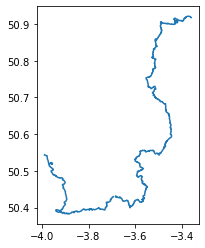

In [3]:
legs_gdf = gpd.read_file("tsasaa_exports.gpkg", layer="legs", crs=3857)
legs_gdf.plot()

## Set Up DF with Key Information
Each model takes the "crow-flies" distance, from hike start to hike end, as the basis for its calculation. To test the accuracy, the model should take the crow-flies distance from hike start to leg end in order to predict the actual distance covered from hike start to leg end. Therefore the following pieces of information are required in the base DataFrame:
* Distance from hike start to leg end as the crow flies
* Cumulative distance hiked thus far

Distances are calculated in miles.

In [4]:
temp_settlements_df = settlements_gdf.sort_values(
    by=["quest", "leg", "interim"],
).copy()

temp_settlements_df["Previous"] = temp_settlements_df["geometry"].shift()
temp_settlements_df["length"] = temp_settlements_df.apply(
    lambda leg: crow_flies(leg["geometry"], leg["Previous"]) if leg["Previous"] else 0,
    axis=1,
)
total_hike_as_crow_flies = temp_settlements_df["length"].sum()

f"Total distance as the crow flies: {int(total_hike_as_crow_flies)} miles"

'Total distance as the crow flies: 474 miles'

In [5]:
base_df = pd.concat(
    [
        legs_gdf[["ending_location"]],
        legs_gdf.apply(
            lambda location: settlements_gdf[settlements_gdf["location"] == location["ending_location"]].iloc[0]["geometry"],
            axis=1,
        ),
        legs_gdf.apply(
            lambda location: crow_flies(
                start=settlements_gdf[settlements_gdf["location"] == location["starting_location"]].iloc[0]["geometry"],
                end=settlements_gdf[settlements_gdf["location"] == location["ending_location"]].iloc[0]["geometry"],
            ),
            axis=1,
        ),
        legs_gdf.apply(
            lambda location: crow_flies(
                start=settlements_gdf[settlements_gdf["location"] == "Princetown"].iloc[0]["geometry"],
                end=settlements_gdf[settlements_gdf["location"] == location["ending_location"]].iloc[0]["geometry"],
            ),
            axis=1,
        ),
        legs_gdf["length"].cumsum(),
    ],
    axis=1,
)

base_df.rename(
    columns={
        "ending_location": "End",
        0: "End Geometry",
        1: "Crow Flies leg/miles",
        2: "Crow Flies from Start/miles",
        "length": "Cumulative Length/miles",
    },
    inplace=True,
)

base_df["Crow Flies from Start via/miles"] = base_df["Crow Flies leg/miles"].cumsum()
base_df.drop(["Crow Flies leg/miles"], inplace=True, axis=1)

base_df

/usr/lib/python3/dist-packages/pandas/core/dtypes/cast.py:121: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


End                                    End Geometry  \
0          Ivybridge   POINT (-3.9210979199011042 50.38871015471641)   
1             Totnes   POINT (-3.6878452093344953 50.43179580853152)   
2           Paignton   POINT (-3.5610615623059565 50.42476074295586)   
3       Newton Abbot    POINT (-3.605141457618043 50.53080540100332)   
4         Teignmouth    POINT (-3.492544678192904 50.54669603069632)   
5          Starcross    POINT (-3.447426648273045 50.62673855516515)   
6             Exeter     POINT (-3.529853369686878 50.7224923726489)   
7          Bickleigh   POINT (-3.5056444853690274 50.85439909901633)   
8  Sampford Peverell  POINT (-3.3779766094563857 50.920790163619586)   

   Crow Flies from Start/miles  Cumulative Length/miles  \
0                    11.618108                17.798777   
1                    15.860442                34.001986   
2                    21.050430                44.958221   
3                    17.281437                57.365376   
4                    22.188532                64.798044   
5                    24.732722                72.480975   
6                    23.727747                82.651868   
7                    30.121495                97.308883   
8                    37.328517               111.765294   

   Crow Flies from Start via/miles  
0                        11.618108  
1                        22.342523  
2                        27.961439  
3                        35.544737  
4                        40.624772  
5                        46.502891  
6                        54.047126  
7                        63.226536  
8                        70.453025

## Models
### Simple Ratio
Assume point A is the start, C is the end, and B is the point reached thus far. We have AC as the crow-flies, and we can calculate AB as the crow-flies, as well as the actual length, therefore:

$$
\frac{AB_{crow-flies}}{AB_{actual}} = \frac{AC_{crow-flies}}{AC_{actual}}
$$

As this ratio is calculated from the data that will be used to test the models, it cannot itself be tested for accuracy (it would always be 100%). It can however give a rough prediction of total hike length.

A simple test could be to predict individual leg lengths, but this would then be inconsistent with the rest of the models.

In [6]:
simple_ratio_df = base_df.copy()
simple_ratio_df["Simple Ratio Prediction/miles"] = simple_ratio_df.apply(
    lambda x: (total_hike_as_crow_flies * x["Cumulative Length/miles"]) / x["Crow Flies from Start/miles"],
    axis=1)

simple_ratio_df

End                                    End Geometry  \
0          Ivybridge   POINT (-3.9210979199011042 50.38871015471641)   
1             Totnes   POINT (-3.6878452093344953 50.43179580853152)   
2           Paignton   POINT (-3.5610615623059565 50.42476074295586)   
3       Newton Abbot    POINT (-3.605141457618043 50.53080540100332)   
4         Teignmouth    POINT (-3.492544678192904 50.54669603069632)   
5          Starcross    POINT (-3.447426648273045 50.62673855516515)   
6             Exeter     POINT (-3.529853369686878 50.7224923726489)   
7          Bickleigh   POINT (-3.5056444853690274 50.85439909901633)   
8  Sampford Peverell  POINT (-3.3779766094563857 50.920790163619586)   

   Crow Flies from Start/miles  Cumulative Length/miles  \
0                    11.618108                17.798777   
1                    15.860442                34.001986   
2                    21.050430                44.958221   
3                    17.281437                57.365376   
4                    22.188532                64.798044   
5                    24.732722                72.480975   
6                    23.727747                82.651868   
7                    30.121495                97.308883   
8                    37.328517               111.765294   

   Crow Flies from Start via/miles  Simple Ratio Prediction/miles  
0                        11.618108                     726.984437  
1                        22.342523                    1017.324170  
2                        27.961439                    1013.487776  
3                        35.544737                    1575.216836  
4                        40.624772                    1385.810019  
5                        46.502891                    1390.664821  
6                        54.047126                    1652.975923  
7                        63.226536                    1533.014738  
8                        70.453025                    1420.811897

## Random Walk

In [7]:
class RandomWalker:
    
    track: gpd.GeoDataFrame
    _adjuster: float
    _direction: float
    _goal: Point
    _interim_goals: list[str]
    _next_interim_goal: str
    _position: Point
    _preferred_total_steps: int
    _previous_goal: Point
    _proximal_to_goal: bool
    _step_count: int
    _step_length: float
    
    def __init__(
        self,
        start: Point,
        goal: Point,
        crow_flies: float,
        step_length: float = 0.014,  # approx 1 mile at this latitude
        ideal_days_walk_length = 15,
    ):
        self._goal = goal
        self._determine_interim_goals()
        self._set_next_interim_goal()
        
        self._adjuster = 1
        self._ideal_days_walk_length = ideal_days_walk_length
        self._step_length = step_length
        self._position = start
        self._previous_goal = start
        self._proximal_to_goal = False
        self._step_count = 0
        self._preferred_total_steps = crow_flies * 2
        self.track = gpd.GeoDataFrame(
            data={
                "leg": [self._step_count],
                "position": [start],
            },
            geometry="position",
            crs=3857,
        )
        logger.info(f"Initialised, finding path from {start} to {goal}")
        # print(f"Initialised, finding path from {start} to {goal}")
        
        while not self._proximal_to_goal:
            self._calculate_direction_of_goal()
            self._randomize_direction()
            
            self._take_step()
            
            self._check_proximity_to_goal()
            # print(f"\n{self._step_count}")

        self.track = pd.concat(
            [
                self.track,
                gpd.GeoDataFrame(
                    data={
                        "leg": [self._step_count + 1],
                        "position": [self._goal],
                    },
                    geometry="position",
                    crs=3857,
                ),
            ],
        )
        self.track.set_index("leg", inplace=True)
                
        return
    
    def _calculate_direction_of_goal(self):
        self._direction = atan2(
            (self._next_interim_goal.x - self._position.x),
            (self._next_interim_goal.y - self._position.y),
        )
        # print(f"Goal direction: {self._direction}")
        
    
    def _randomize_direction(self):
        # adjuster allows random movement at start, but makes routes more direct at end of legs

        if crow_flies(self._position, self._previous_goal) > self._ideal_days_walk_length * self._step_length:
            self._adjuster = 1 - (crow_flies(self._position, self._previous_goal) / self._ideal_days_walk_length)
        else:
            self._adjuster = 0
        
        self._direction = random.triangular(
            low=self._direction - (pi*self._adjuster),
            high=self._direction + (pi*self._adjuster),
            mode=self._direction,
        )
        # print(f"Random direction: {self._direction}")
        
    def _take_step(self):
        new_position: Point = Point(
            self._position.x + (self._step_length*sin(self._direction)),
            self._position.y + (self._step_length*cos(self._direction)),
        )
        self._position = new_position
        self._step_count += 1
        self.track = pd.concat(
            [
                self.track, 
                gpd.GeoDataFrame(
                    data={
                        "leg": [self._step_count], 
                        "position": [self._position],
                    },
                    geometry="position",
                    crs=3857,
                ),
            ],
        )
        # print(f"Postion: {self._position}")
        
    def _check_proximity_to_goal(self):
        if self._position.distance(self._goal) <= 1.5 * self._step_length:
            self._proximal_to_goal = True
        
        if self._position.distance(self._next_interim_goal) <= 1.5 * self._step_length:
            self._previous_goal = self._next_interim_goal
            self._set_next_interim_goal()
        
    
    def _determine_interim_goals(self):
        settlements = settlements_gdf.sort_values(
            by=["quest", "leg", "interim"],
        )["location"].to_list()

        self._interim_goals = settlements[:settlements.index(settlements_gdf[settlements_gdf["geometry"] == self._goal].iloc[0]["location"]) + 1]
    
    def _set_next_interim_goal(self):
        if self._interim_goals:
            self._next_interim_goal = settlements_gdf[settlements_gdf["location"] == self._interim_goals.pop(0)].iloc[0]["geometry"]
            self._adjuster = 1

Setup walk from Princetown to Exeter.

                  position
leg                       
0    POINT (-3.996 50.550)
1    POINT (-3.996 50.564)
2    POINT (-4.007 50.555)
3    POINT (-3.993 50.556)
4    POINT (-4.002 50.567)
..                     ...
139  POINT (-3.494 50.699)
140  POINT (-3.494 50.713)
141  POINT (-3.499 50.726)
142  POINT (-3.512 50.720)
143  POINT (-3.530 50.722)

[144 rows x 1 columns]


<AxesSubplot:>

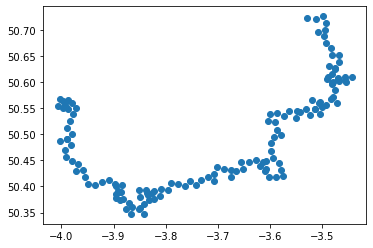

In [8]:
random.seed(24)
walk = RandomWalker(
    start=Point(settlements_gdf[settlements_gdf["location"] == "Princetown"].iloc[0]["geometry"]),
    goal=Point(settlements_gdf[settlements_gdf["location"] == "Exeter"].iloc[0]["geometry"]),
    crow_flies=60,
)

print(walk.track)
walk.track.plot()

In [9]:
def run_random_walk(
    end_geom: Point,
    end: str,
    crow_flies: float,
    actual: float,
) -> float:
    
    print(f"Predicting up to {end}")
    
    walk = RandomWalker(
        start=Point(settlements_gdf[settlements_gdf["location"] == "Princetown"].iloc[0]["geometry"]),
        goal=end_geom,
        crow_flies=crow_flies,
    )
    track = LineString( [[waypoint.x, waypoint.y] for waypoint in walk.track.geometry.values] )
    predicted = track.length * 69.2
    
    full_walk = RandomWalker(
        start=Point(settlements_gdf[settlements_gdf["location"] == "Princetown"].iloc[0]["geometry"]),
        goal=Point(settlements_gdf[settlements_gdf["location"] == "Durham"].iloc[0]["geometry"]),
        crow_flies=total_hike_as_crow_flies,
        ideal_days_walk_length=total_hike_as_crow_flies,
    )
    full_track = LineString( [[waypoint.x, waypoint.y] for waypoint in full_walk.track.geometry.values] )
    predicted_total = full_track.length * 69.2

    return predicted, predicted_total


random.seed(24)
random_walk_df = base_df.copy()
random_walk_df[[
    "Random Walk Leg Prediction/miles", 
    "Random Walk Prediction/miles",
]] = random_walk_df.apply(
    lambda x: run_random_walk(
        end_geom=x["End Geometry"],
        end=x["End"],
        crow_flies=x["Crow Flies from Start via/miles"],
        actual=x["Cumulative Length/miles"],
    ),
    axis=1,
    result_type="expand",
)

random_walk_df


Predicting up to Ivybridge
Predicting up to Totnes
Predicting up to Paignton
Predicting up to Newton Abbot
Predicting up to Teignmouth
Predicting up to Starcross
Predicting up to Exeter
Predicting up to Bickleigh
Predicting up to Sampford Peverell


End                                    End Geometry  \
0          Ivybridge   POINT (-3.9210979199011042 50.38871015471641)   
1             Totnes   POINT (-3.6878452093344953 50.43179580853152)   
2           Paignton   POINT (-3.5610615623059565 50.42476074295586)   
3       Newton Abbot    POINT (-3.605141457618043 50.53080540100332)   
4         Teignmouth    POINT (-3.492544678192904 50.54669603069632)   
5          Starcross    POINT (-3.447426648273045 50.62673855516515)   
6             Exeter     POINT (-3.529853369686878 50.7224923726489)   
7          Bickleigh   POINT (-3.5056444853690274 50.85439909901633)   
8  Sampford Peverell  POINT (-3.3779766094563857 50.920790163619586)   

   Crow Flies from Start/miles  Cumulative Length/miles  \
0                    11.618108                17.798777   
1                    15.860442                34.001986   
2                    21.050430                44.958221   
3                    17.281437                57.365376   
4                    22.188532                64.798044   
5                    24.732722                72.480975   
6                    23.727747                82.651868   
7                    30.121495                97.308883   
8                    37.328517               111.765294   

   Crow Flies from Start via/miles  Random Walk Leg Prediction/miles  \
0                        11.618108                         26.639534   
1                        22.342523                         47.617049   
2                        27.961439                         69.121551   
3                        35.544737                         91.225166   
4                        40.624772                        115.423588   
5                        46.502891                        125.914103   
6                        54.047126                        128.314490   
7                        63.226536                        160.984253   
8                        70.453025                        183.804616   

   Random Walk Prediction/miles  
0                   1053.790975  
1                    998.050565  
2                   1033.381718  
3                   1028.490494  
4                    998.774956  
5                   1005.463093  
6                   1016.136164  
7                   1021.366255  
8                   1009.049914

## All Predictions

In [10]:
all_models = pd.merge(
    simple_ratio_df,
    random_walk_df,
    on=[
        "End",
        "End Geometry",
        "Crow Flies from Start/miles",
        "Crow Flies from Start via/miles",
        "Cumulative Length/miles",
    ],
)

all_models.drop(
    [
        "End Geometry",
        "Crow Flies from Start/miles",
        "Crow Flies from Start via/miles",
        "Cumulative Length/miles",
        "Random Walk Leg Prediction/miles",
    ],
    axis=1,
    inplace=True,
)

all_models["Ensemble"] = all_models.apply(
    lambda prediction: mean(
        [prediction["Simple Ratio Prediction/miles"], prediction["Random Walk Prediction/miles"]]
    ),
    axis=1,
)

TypeError: unhashable type: 'Point'

In [ ]:
ensemble: float = all_models.iloc[-1][["Ensemble"]]

print(f"Current total mileage prediction: {int(ensemble)} miles")